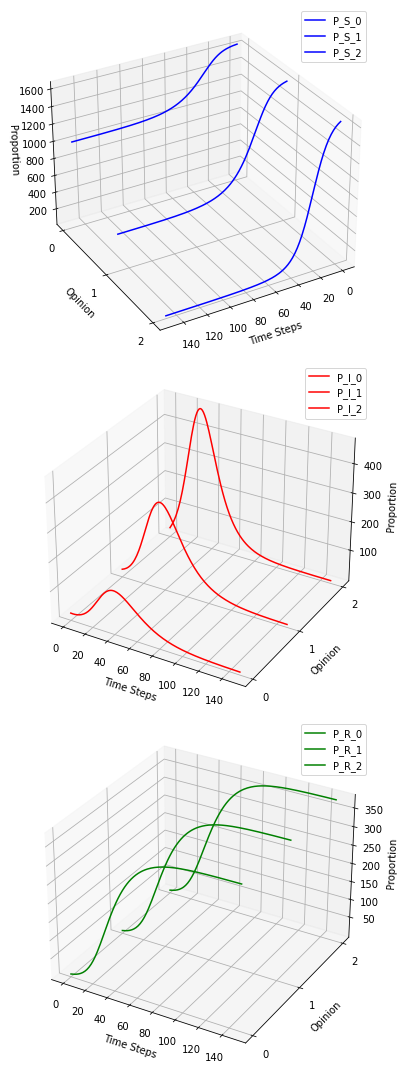

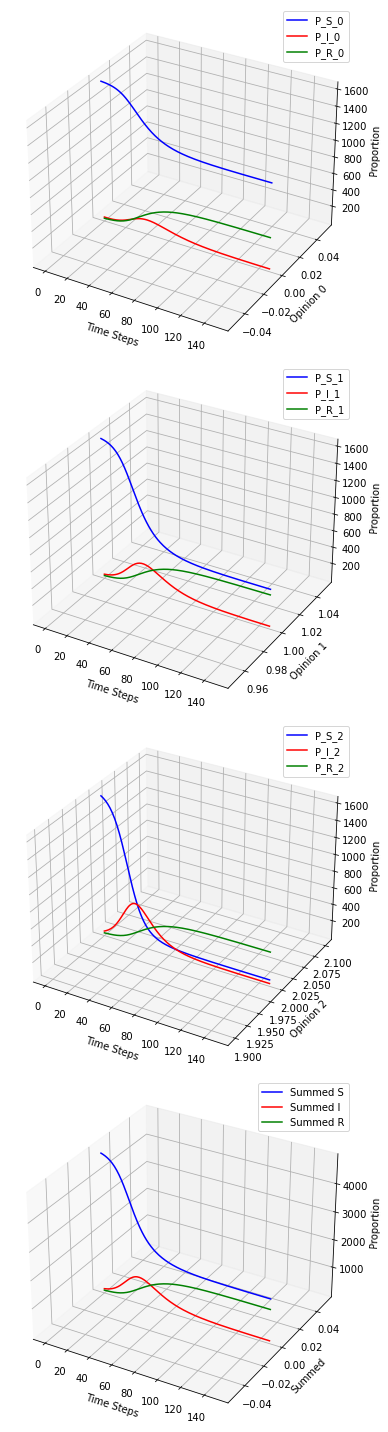

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# We will define the parameters and initial conditions at first
N = 5000  # Total population considered by us 
int_I = 0.01 * N  # Initial infected individuals
int_R = 0  # Initial recovered individuals
int_S = N - int_I - int_R  # Initial susceptible individuals

# The rate of disease transmission and recovery
beta = 0.7  # This is the transmission rate
gamma = 0.01  # This is the recovery rate

# Simulation time parameters are as follows
MaxTime = 150  # This is the total simulation time in days
RunTime = np.linspace(0, MaxTime, MaxTime)  # This is the time array for plotting

# Number of opinion groups (indexed from 0 to n), which is also can be changed accordingly if needed
n = 2  # The total number of opinion groups

# Below is the function to calculate the probability distribution over the opinions
def pi(q, n):
    # This is basically the softmax function that we are using to compute the probability distribution
    return np.exp(q) / np.sum(np.exp(np.arange(n + 1)))

# Here comes the initialization of initial values for all the S, I, R in each opinion group
initial_values = {f'P_S_{i}': float(int_S / (n + 1)) for i in range(n + 1)}
initial_values.update({f'P_I_{i}': float(int_I / (n + 1)) for i in range(n + 1)})
initial_values.update({f'P_R_{i}': float(int_R / (n + 1)) for i in range(n + 1)})

# At below, these are actually the differential equations for the SIR model with opinions
def dS(t, y, row, O, beta, N, n):
    # This is the rate of change of susceptible individuals in opinion group O
    return -pi(O, n) * beta * row[f'P_S_{O}'] * sum(row[f'P_I_{j}'] for j in range(n + 1)) / N

def dI(t, y, row, O, beta, gamma, N, n):
    # This is the rate of change of infected individuals in opinion group O
    return pi(O, n) * beta * row[f'P_S_{O}'] * sum(row[f'P_I_{j}'] for j in range(n + 1)) / N - (3 ** n) * gamma * row[f'P_I_{O}']

def dR(t, y, row, O, gamma, n):
    # This is the rate of change of recovered individuals in opinion group O
    return gamma * sum(row[f'P_I_{j}'] for j in range(n + 1))

# In the following, we have implemented the runge-Kutta method for solving differential equations
def runge(f, t, y0, *args):
    n = len(t)
    U = np.zeros(n)
    U[0] = y0
    h = t[1] - t[0]  # Step size is based on the t array

    for j in range(n - 1):
        k1 = f(t[j], U[j], *args)
        k2 = f(t[j] + h / 2, U[j] + h / 2 * k1, *args)
        U[j + 1] = U[j] + h * k2

    return U[-1]

# Now we will deal with the functions to update the proportions of S, I, and R in each opinion group
def update_proportions_S(row, beta, N, n, t):
    for i in range(n + 1):
        row[f'P_S_{i}'] = runge(dS, t, row[f'P_S_{i}'], row, i, beta, N, n)
    return row

def update_proportions_I(row, beta, gamma, N, n, t):
    for i in range(n + 1):
        row[f'P_I_{i}'] = runge(dI, t, row[f'P_I_{i}'], row, i, beta, gamma, N, n)
    return row

def update_proportions_R(row, gamma, n, t):
    for i in range(n + 1):
        row[f'P_R_{i}'] = runge(dR, t, row[f'P_R_{i}'], row, i, gamma, n)
    return row

# The main simulation function is as follows
def run_simulation(initial_values, beta, gamma, steps, N, n):
    t = np.linspace(0, 1, 2)  # This is the time step for the Runge-Kutta method we have used before 

    # Now we will define the column names for the DataFrame
    columns = [f'P_S_{i}' for i in range(n + 1)] + [f'P_I_{i}' for i in range(n + 1)] + [f'P_R_{i}' for i in range(n + 1)]
    
    # We will create an empty DataFrame with the specified columns
    data = pd.DataFrame(columns=columns)

    # Initialization of the row with the initial values
    row = initial_values.copy()

    # Now we will run the simulation for the specified number of steps
    for _ in range(steps):
        # Let us update the proportions for S, I, R in each opinion group
        row = update_proportions_S(row, beta, N, n, t)
        row = update_proportions_I(row, beta, gamma, N, n, t)
        row = update_proportions_R(row, gamma, n, t)
        
        # Appending the updated row to the DataFrame
        data = pd.concat([data, pd.DataFrame([row])], ignore_index=True)

    return data

# Now we will define a function to plot the simulation results in 3D
def plot_simulation_3d(data, n):
    num_plots = n + 1  # This is the total number of opinion groups
    fig = plt.figure(figsize=(20, 15))  # For creating a figure

    # We will plot all P_S in one plot with adjusted perspective
    ax = fig.add_subplot(3, 1, 1, projection='3d')
    colors = ['blue', 'blue', 'blue']  # We have used blue color for all P_S
    for i in range(num_plots):
        ax.plot(np.arange(len(data)), np.full(len(data), i), data[f'P_S_{i}'], label=f'P_S_{i}', color=colors[i])
    ax.set_xlabel('Time Steps')
    ax.set_ylabel('Opinion')
    ax.set_zlabel('Proportion')
    ax.set_yticks(np.arange(num_plots))  # We have set yticks to ensure equal spacing
    ax.legend()
    ax.view_init(elev=30, azim=60)  # We have adjusted the view angle a bit for the better understanding of P_S

    #  We will plot all P_I in one plot with adjusted perspective
    ax = fig.add_subplot(3, 1, 2, projection='3d')
    colors = ['red', 'red', 'red']  # We have used red color for all P_S
    for i in range(num_plots):
        ax.plot(np.arange(len(data)), np.full(len(data), i), data[f'P_I_{i}'], label=f'P_I_{i}', color=colors[i])
    ax.set_xlabel('Time Steps')
    ax.set_ylabel('Opinion')
    ax.set_zlabel('Proportion')
    ax.set_yticks(np.arange(num_plots))  # We have again set yticks to ensure equal spacing
    ax.legend()

    # We will plot all P_R in one plot with adjusted perspective
    ax = fig.add_subplot(3, 1, 3, projection='3d')
    colors = ['green', 'green', 'green']  # We have used green color for all P_S
    for i in range(num_plots):
        ax.plot(np.arange(len(data)), np.full(len(data), i), data[f'P_R_{i}'], label=f'P_R_{i}', color=colors[i])
    ax.set_xlabel('Time Steps')
    ax.set_ylabel('Opinion')
    ax.set_zlabel('Proportion')
    ax.set_yticks(np.arange(num_plots))  # We have again set yticks to ensure equal spacing
    ax.legend()

    plt.tight_layout()  # Here we have adjusted the subplots to fit into the figure area
    plt.show()

    # In the following, this is for the additional plots for individual opinion groups and summed compartments
    fig, axes = plt.subplots(4, 1, figsize=(15, 20), subplot_kw={'projection': '3d'})

    for i in range(num_plots):
        # Now we will plot S, I, R together for each opinion group in 3D
        ax = axes[i]
        ax.plot(np.arange(len(data)), np.full(len(data), i), data[f'P_S_{i}'], label=f'P_S_{i}', color='blue')
        ax.plot(np.arange(len(data)), np.full(len(data), i), data[f'P_I_{i}'], label=f'P_I_{i}', color='red')
        ax.plot(np.arange(len(data)), np.full(len(data), i), data[f'P_R_{i}'], label=f'P_R_{i}', color='green')
        ax.set_xlabel('Time Steps')
        ax.set_ylabel(f'Opinion {i}')
        ax.set_zlabel('Proportion')
        ax.legend()

    # Let us sum up the proportions across all the opinion groups
    summed_S = data[[f'P_S_{i}' for i in range(num_plots)]].sum(axis=1)
    summed_I = data[[f'P_I_{i}' for i in range(num_plots)]].sum(axis=1)
    summed_R = data[[f'P_R_{i}' for i in range(num_plots)]].sum(axis=1)

    # Now we will plot the summed S, I, R proportions over time
    ax = axes[3]
    ax.plot(np.arange(len(data)), np.zeros(len(data)), summed_S, label='Summed S', color='blue')
    ax.plot(np.arange(len(data)), np.zeros(len(data)), summed_I, label='Summed I', color='red')
    ax.plot(np.arange(len(data)), np.zeros(len(data)), summed_R, label='Summed R', color='green')
    ax.set_xlabel('Time Steps')
    ax.set_ylabel('Summed')
    ax.set_zlabel('Proportion')
    ax.legend()

    plt.tight_layout()  # Here we have adjusted subplots to fit into the figure area
    plt.show()

# Now we will run the simulation and plot the results
data = run_simulation(initial_values, beta, gamma, MaxTime, N, n)
plot_simulation_3d(data, n)
